In [1]:
import statsmodels
import numpy as np
import torch
import statsmodels.api as sm
import statsmodels.formula.api as smf
import pandas
import pyfaidx
import numpy
import pyBigWig
from tqdm import tqdm
import math
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

/users/myin25/miniconda/envs/copro/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.25.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [62]:
def one_hot_encode(sequence, alphabet=['A', 'C', 'G', 'T'], dtype='int8', 
    desc=None, verbose=False, **kwargs):
    """Converts a string or list of characters into a one-hot encoding.

    This function will take in either a string or a list and convert it into a
    one-hot encoding. If the input is a string, each character is assumed to be
    a different symbol, e.g. 'ACGT' is assumed to be a sequence of four 
    characters. If the input is a list, the elements can be any size.

    Although this function will be used here primarily to convert nucleotide
    sequences into one-hot encoding with an alphabet of size 4, in principle
    this function can be used for any types of sequences.

    Parameters
    ----------
    sequence : str or list
        The sequence to convert to a one-hot encoding.

    alphabet : set or tuple or list
        A pre-defined alphabet where the ordering of the symbols is the same
        as the index into the returned tensor, i.e., for the alphabet ['A', 'B']
        the returned tensor will have a 1 at index 0 if the character was 'A'.
        Characters outside the alphabet are ignored and none of the indexes are
        set to 1. Default is ['A', 'C', 'G', 'T'].

    dtype : str or numpy.dtype, optional
        The data type of the returned encoding. Default is int8.

    desc : str or None, optional
        The title to display in the progress bar.

    verbose : bool or str, optional
        Whether to display a progress bar. If a string is passed in, use as the
        name of the progressbar. Default is False.

    kwargs : arguments
        Arguments to be passed into tqdm. Default is None.

    Returns
    -------
    ohe : numpy.ndarray
        A binary matrix of shape (alphabet_size, sequence_length) where
        alphabet_size is the number of unique elements in the sequence and
        sequence_length is the length of the input sequence.
    """

    d = verbose is False

    if isinstance(sequence, str):
        sequence = list(sequence)

    alphabet_lookup = {char: i for i, char in enumerate(alphabet)}

    ohe = numpy.zeros((len(sequence), len(alphabet)), dtype=dtype)
    for i, char in tqdm(enumerate(sequence), disable=d, desc=desc, **kwargs):
        idx = alphabet_lookup.get(char, -1)
        if idx != -1:
            ohe[i, idx] = 1

    return ohe

def extract_loci(loci, sequences, signals=None, controls=None, chroms=None, 
    in_window=2114, out_window=1000, max_jitter=0, min_counts=None,
    max_counts=None, n_loci=None, verbose=False):
    """Extract sequences and signals at coordinates from a locus file.

    This function will take in genome-wide sequences, signals, and optionally
    controls, and extract the values of each at the coordinates specified in
    the locus file/s and return them as tensors.

    Signals and controls are both lists with the length of the list, n_s
    and n_c respectively, being the middle dimension of the returned
    tensors. Specifically, the returned tensors of size 
    (len(loci), n_s/n_c, (out_window/in_wndow)+max_jitter*2).

    The values for sequences, signals, and controls, can either be filepaths
    or dictionaries of numpy arrays or a mix of the two. When a filepath is 
    passed in it is loaded using pyfaidx or pyBigWig respectively.   

    Parameters
    ----------
    loci: str or pandas.DataFrame or list/tuple of such
        Either the path to a bed file or a pandas DataFrame object containing
        three columns: the chromosome, the start, and the end, of each locus
        to train on. Alternatively, a list or tuple of strings/DataFrames where
        the intention is to train on the interleaved concatenation, i.e., when
        you want to train on peaks and negatives.

    sequences: str or dictionary
        Either the path to a fasta file to read from or a dictionary where the
        keys are the unique set of chromosoms and the values are one-hot
        encoded sequences as numpy arrays or memory maps.

    signals: list of strs or list of dictionaries or None, optional
        A list of filepaths to bigwig files, where each filepath will be read
        using pyBigWig, or a list of dictionaries where the keys are the same
        set of unique chromosomes and the values are numpy arrays or memory
        maps. If None, no signal tensor is returned. Default is None.

    controls: list of strs or list of dictionaries or None, optional
        A list of filepaths to bigwig files, where each filepath will be read
        using pyBigWig, or a list of dictionaries where the keys are the same
        set of unique chromosomes and the values are numpy arrays or memory
        maps. If None, no control tensor is returned. Default is None. 

    chroms: list or None, optional
        A set of chromosomes to extact loci from. Loci in other chromosomes
        in the locus file are ignored. If None, all loci are used. Default is
        None.

    in_window: int, optional
        The input window size. Default is 2114.

    out_window: int, optional
        The output window size. Default is 1000.

    max_jitter: int, optional
        The maximum amount of jitter to add, in either direction, to the
        midpoints that are passed in. Default is 0.

    min_counts: float or None, optional
        The minimum number of counts, summed across the length of each example
        and across all tasks, needed to be kept. If None, no minimum. Default 
        is None.

    max_counts: float or None, optional
        The maximum number of counts, summed across the length of each example
        and across all tasks, needed to be kept. If None, no maximum. Default 
        is None.  

    n_loci: int or None, optional
        A cap on the number of loci to return. Note that this is not the
        number of loci that are considered. The difference is that some
        loci may be filtered out for various reasons, and those are not
        counted towards the total. If None, no cap. Default is None.

    verbose: bool, optional
        Whether to display a progress bar while loading. Default is False.

    Returns
    -------
    seqs: torch.tensor, shape=(n, 4, in_window+2*max_jitter)
        The extracted sequences in the same order as the loci in the locus
        file after optional filtering by chromosome.

    signals: torch.tensor, shape=(n, len(signals), out_window+2*max_jitter)
        The extracted signals where the first dimension is in the same order
        as loci in the locus file after optional filtering by chromosome and
        the second dimension is in the same order as the list of signal files.
        If no signal files are given, this is not returned.

    controls: torch.tensor, shape=(n, len(controls), out_window+2*max_jitter)
        The extracted controls where the first dimension is in the same order
        as loci in the locus file after optional filtering by chromosome and
        the second dimension is in the same order as the list of control files.
        If no control files are given, this is not returned.
    """

    seqs, signals_, controls_ = [], [], []
    in_width, out_width = in_window // 2, out_window // 2

    # Load the sequences
    if isinstance(sequences, str):
        sequences = pyfaidx.Fasta(sequences)

    names = ['chrom', 'start', 'end']
    if not isinstance(loci, (tuple, list)):
        loci = [loci]

    loci_dfs = []
    for i, df in enumerate(loci):
        if isinstance(df, str):
            try:
                df = pandas.read_csv(df, sep='\t', usecols=[0, 1, 2], 
                    header=None, index_col=False, names=names)
            except:
                print("File Doesn't Exist!")
                return
            df['idx'] = numpy.arange(len(df)) * len(loci) + i
        loci_dfs.append(df)

    loci = pandas.concat(loci_dfs).set_index("idx").sort_index().reset_index(drop=True)

    if chroms is not None:
        loci = loci[numpy.isin(loci['chrom'], chroms)]

    # Load the signal and optional control tracks if filenames are given
    _signals = []
    if signals is not None:
        for i, signal in enumerate(signals):
            if isinstance(signal, str):
                try:
                    signal = pyBigWig.open(signal)
                except:
                    print("Null File")
                    return
            _signals.append(signal)

        signals = _signals

    _controls = []
    if controls is not None:
        for i, control in enumerate(controls):
            if isinstance(control, str):
                control = pyBigWig.open(control, "r")
            _controls.append(control)

        controls = _controls

    desc = "Loading Loci"
    d = not verbose

    max_width = max(in_width, out_width)
    loci_count = 0

    # print(loci)
    # print(loci.values)
    for chrom, start, end in tqdm(loci.values, disable=d, desc=desc):
        mid = start + (end - start) // 2

        if start - max_width - max_jitter < 0:
            continue

        if end + max_width + max_jitter >= len(sequences[chrom]):
            continue

        if n_loci is not None and loci_count == n_loci:
            break 

        start = mid - out_width - max_jitter
        end = mid + out_width + max_jitter

        # Extract the signal from each of the signal files
        if signals is not None:
            signals_.append([])
            for signal in signals:
                if isinstance(signal, dict):
                    signal_ = signal[chrom][start:end]
                else:
                    signal_ = signal.values(chrom, start, end, numpy=True)
                    signal_ = numpy.nan_to_num(signal_)

                signals_[-1].append(signal_)

        # For the sequences and controls extract a window the size of the input
        start = mid - in_width - max_jitter
        end = mid + in_width + max_jitter

        # Extract the controls from each of the control files
        if controls is not None:
            controls_.append([])
            for control in controls:
                if isinstance(control, dict):
                    control_ = control[chrom][start:end]
                else:
                    control_ = control.values(chrom, start, end, numpy=True)
                    control_ = numpy.nan_to_num(control_)

                controls_[-1].append(control_)

        # Extract the sequence
        if isinstance(sequences, dict):
            seq = sequences[chrom][start:end].T
        else:
            seq = one_hot_encode(sequences[chrom][start:end].seq.upper(), 
                alphabet=['A', 'C', 'G', 'T']).T

        seqs.append(seq)
        loci_count += 1

    seqs = torch.tensor(numpy.array(seqs), dtype=torch.float32)

    if signals is not None:
        signals_ = torch.tensor(numpy.array(signals_), dtype=torch.float32)

        idxs = torch.ones(signals_.shape[0], dtype=torch.bool)
        if max_counts is not None:
            idxs = (idxs) & (signals_.sum(dim=(1, 2)) < max_counts)
        if min_counts is not None:
            idxs = (idxs) & (signals_.sum(dim=(1, 2)) > min_counts)

        if controls is not None:
            controls_ = torch.tensor(numpy.array(controls_), dtype=torch.float32)
            return seqs[idxs], signals_[idxs], controls_[idxs]

        return seqs[idxs], signals_[idxs]
    else:
        if controls is not None:
            controls_ = torch.tensor(numpy.array(controls_), dtype=torch.float32)
            return seqs, controls_

        return seqs

def extract_signals(loci, sequences, signals=None, controls=None, chroms=None, 
    in_window=2114, out_window=1000, max_jitter=0, min_counts=None,
    max_counts=None, n_loci=None, verbose=False):
    
    # print(loci)
    # print(signals)
    
    seqs, signals_, controls_ = [], [], []
    in_width, out_width = in_window // 2, out_window // 2


    names = ['chrom', 'start', 'end']
    if not isinstance(loci, (tuple, list)):
        loci = [loci]

    loci_dfs = []
    for i, df in enumerate(loci):
        if isinstance(df, str):
            try:
                df = pandas.read_csv(df, sep='\t', usecols=[0, 1, 2], 
                    header=None, index_col=False, names=names)
            except:
                print("File Doesn't Exist!")
                return
            df['idx'] = numpy.arange(len(df)) * len(loci) + i
        loci_dfs.append(df)

    loci = pandas.concat(loci_dfs).set_index("idx").sort_index().reset_index(drop=True)

    if chroms is not None:
        loci = loci[numpy.isin(loci['chrom'], chroms)]

    # Load the signal and optional control tracks if filenames are given
    _signals = []
    if signals is not None:
        for i, signal in enumerate(signals):
            if isinstance(signal, str):
                try:
                    signal = pyBigWig.open(signal)
                except:
                    print("Null File")
                    return
            _signals.append(signal)

        signals = _signals

    _controls = []
    if controls is not None:
        for i, control in enumerate(controls):
            if isinstance(control, str):
                control = pyBigWig.open(control, "r")
            _controls.append(control)

        controls = _controls

    desc = "Loading Loci"
    d = not verbose

    max_width = max(in_width, out_width)
    loci_count = 0

    # print(loci)
    # print(loci.values)
    for chrom, start, end in tqdm(loci.values, disable=d, desc=desc):
        mid = start + (end - start) // 2

        if start - max_width - max_jitter < 0:
            continue

        if n_loci is not None and loci_count == n_loci:
            break 

        start = mid - out_width - max_jitter
        end = mid + out_width + max_jitter

        # Extract the signal from each of the signal files
        if signals is not None:
            signals_.append([])
            for signal in signals:
                if isinstance(signal, dict):
                    signal_ = signal[chrom][start:end]
                else:
                    try:
                        signal_ = signal.values(chrom, start, end, numpy=True)
                        signal_ = numpy.nan_to_num(signal_)
                    except:
                        print("error with interval bounds")
                        print(signal)
                        print(chrom)
                        print(start)
                        print(end)

                signals_[-1].append(signal_)

        # For the sequences and controls extract a window the size of the input
        start = mid - in_width - max_jitter
        end = mid + in_width + max_jitter

        # Extract the controls from each of the control files
        if controls is not None:
            controls_.append([])
            for control in controls:
                if isinstance(control, dict):
                    control_ = control[chrom][start:end]
                else:
                    control_ = control.values(chrom, start, end, numpy=True)
                    control_ = numpy.nan_to_num(control_)

                controls_[-1].append(control_)

        loci_count += 1

    if signals is not None:
        signals_ = torch.tensor(numpy.array(signals_), dtype=torch.float32)

        idxs = torch.ones(signals_.shape[0], dtype=torch.bool)
        if max_counts is not None:
            idxs = (idxs) & (signals_.sum(dim=(1, 2)) < max_counts)
        if min_counts is not None:
            idxs = (idxs) & (signals_.sum(dim=(1, 2)) > min_counts)

        return signals_[idxs]
    
def getlinmodel(cell_type, histone_type):
    signals = [root + "data/procap/observed/{}/5prime.pos.bigWig".format(cell_type), root + "data/procap/observed/{}/5prime.neg.bigWig".format(cell_type)]

    actual_levels = torch.sum(torch.sum(extract_signals(merged_peak_path, sequences, signals=signals), dim=1), dim=1)
    actual_levels = actual_levels.numpy()
    histone_levels = torch.sum(torch.sum(extract_signals(merged_peak_path, sequences, signals=[histone_paths[histone_type][cell_type]]), dim=1), dim=1)
    histone_levels = histone_levels.numpy()
    dat = pandas.DataFrame()
    dat['actual_levels'] = np.log(actual_levels + 1)
    dat['histone_levels'] = histone_levels

    results = smf.ols('actual_levels ~ histone_levels', data=dat).fit()
    print(results.summary())

def getlinmodel_mult(cell_type, histone_types):
    signals = [root + "data/procap/observed/{}/5prime.pos.bigWig".format(cell_type), root + "data/procap/observed/{}/5prime.neg.bigWig".format(cell_type)]

    actual_levels = torch.sum(torch.sum(extract_signals(merged_peak_path, sequences, signals=signals), dim=1), dim=1)
    actual_levels = actual_levels.numpy()
    dat = pandas.DataFrame()
    dat['actual_levels'] = np.log(actual_levels + 1)
    for histone_type in histone_types:
        histone_levels = torch.sum(torch.sum(extract_signals(merged_peak_path, sequences, signals=[histone_paths[histone_type][cell_type]]), dim=1), dim=1)
        histone_levels = histone_levels.numpy()
        dat[histone_type] = histone_levels

    results = smf.ols('actual_levels ~ ' + '+ '.join(histone_types), data=dat).fit()
    print(results.summary())

def preloaded_getlinmodel_mult(cell_type, histone_types, histone_levels, interact=False):
    if interact == False:
        actual_levels = initiation_levels[cell_type]
        actual_levels = actual_levels.numpy()
        dat = pandas.DataFrame()
        dat['actual_levels'] = np.log(actual_levels + 1)
        for histone_type in histone_types:
            if (cell_type == 'CACO2' and histone_type in ['H3K27ac', 'H3K9ac', 'H3K79me2']) or (cell_type == 'A673' and histone_type in ['H3K9ac', 'H3K79me2']):
                hlevels = np.zeros((len(histone_levels[cell_type]['H3K9me3'])))
            else:
                hlevels = torch.sum(torch.sum(histone_levels[cell_type][histone_type], dim=1), dim=1)
                hlevels = hlevels.numpy()
            dat[histone_type] = hlevels

            
        results = smf.ols('actual_levels ~ ' + '+ '.join(histone_types), data=dat).fit()
        print(results.summary())
    else:
        actual_levels = initiation_levels[cell_type]
        actual_levels = actual_levels.numpy()
        dat = pandas.DataFrame()
        dat['actual_levels'] = np.log(actual_levels + 1)
        
        allhistnames = []
        
        for histone_type in histone_types:
            hlevels = torch.sum(torch.sum(histone_levels[cell_type][histone_type], dim=1), dim=1)
            hlevels = hlevels.numpy()
            dat[histone_type] = hlevels
            allhistnames.append(histone_type)
        
        for histone_type1 in histone_types:
            for histone_type2 in histone_types:
                dat['{}:{}'.format(histone_type1, histone_type2)] = dat[histone_type1]*dat[histone_type2]
                allhistnames.append('{}:{}'.format(histone_type1, histone_type2))
        
        results = smf.ols('actual_levels ~ ' + '+ '.join(allhistnames), data=dat).fit()
        print(results.summary())
    return results

def preloaded_getlinmodel_diff(cell_type1, cell_type2, histone_types, histone_levels, interact=False, dynamic=False, threshold=0.05, table=False):
    diff_levels = torch.log(initiation_levels[cell_type1] + 1) - torch.log(initiation_levels[cell_type2] + 1)
    # Square the initiation residuals to exaggerate larger differences
    # diff_levels = torch.square(initiation_levels[cell_type1] - initiation_levels[cell_type2])
    diff_levels = diff_levels.numpy()
    
    # Create empty DataFrame to store data in
    dat = pandas.DataFrame()
    terms = []
    dat['diff_levels'] = diff_levels
    
    for histone_type in histone_types: # Iterate through each kind of histone and calculate residual
        # Check that cell_type1 shouldn't be all zeros
        if (cell_type1 in missing.keys()) and (histone_type in missing[cell_type1]):
            hlevels1 = numpy.zeros(len(initiation_levels[cell_type1]))
        else: # Get histone_levels
            hlevels1 = torch.sum(histone_levels[cell_type1][histone_type], dim=[1, 2]).numpy()
        
        # Add to DataFrame
        dat[histone_type + cell_type1] = hlevels1
        terms.append(histone_type + cell_type1)

        # Check that cell_type2 shouldn't be all zeros
        if (cell_type2 in missing.keys()) and (histone_type in missing[cell_type2]):
            hlevels2 = numpy.zeros(len(initiation_levels[cell_type2]))
        else: # Get histone levels
            hlevels2 = torch.sum(histone_levels[cell_type2][histone_type], dim=[1, 2]).numpy()
        
        # Add to DataFrame
        dat[histone_type + cell_type2] = hlevels2
        terms.append(histone_type + cell_type2)

    if interact == True:
        for histone_type1 in histone_types:
            for histone_type2 in histone_types:
                if histone_type1 != histone_type2:
                    tempdat = pandas.DataFrame()

                    tempdat['{}_{}_{}'.format(histone_type1, histone_type2, cell_type1)] = dat[histone_type1 + cell_type1]*dat[histone_type2 + cell_type1]
                    terms.append('{}_{}_{}'.format(histone_type1, histone_type2, cell_type1))
                    tempdat['{}_{}_{}'.format(histone_type1, histone_type2, cell_type2)] = dat[histone_type1 + cell_type2]*dat[histone_type2 + cell_type2]
                    terms.append('{}_{}_{}'.format(histone_type1, histone_type2, cell_type2))

                    dat = pandas.concat([dat, tempdat], axis=1)
    
    results = smf.ols('diff_levels ~' + ' + '.join(terms), data=dat).fit()
    
    # print(results.summary())
    
    removed = []
    
    if dynamic == True: # dynamically improve model
        for i in range(5):
            pvalues = results.pvalues
            newterms = []

            for i in range(1, len(pvalues)):
                if (not math.isnan(pvalues[i])) and (pvalues[i] < threshold):
                    newterms.append(terms[i-1])
                else:
                    removed.append(terms[i-1])

            terms = newterms
            results = smf.ols('diff_levels ~' + ' + '.join(terms), data=dat).fit()
    
    if table == True and interact == True:
        params = results.params
        
        data_1 = np.full((len(histone_types), len(histone_types)), np.nan)
        data_2 = np.full((len(histone_types), len(histone_types)), np.nan)
        
        for i in range(8):
            histone_type1 = histone_types[i]
            for j in range(8):
                histone_type2 = histone_types[j]
                
                interact_1 = '{}_{}_{}'.format(histone_type1, histone_type2, cell_type1)
                interact_2 = '{}_{}_{}'.format(histone_type1, histone_type2, cell_type2)
                
                
                if interact_1 in terms:
                    # data_1[i][j] = str(round(pvalues[terms.index(interact_1)], 4))
                    data_1[i][j] = params[terms.index(interact_1) + 1]
                if interact_2 in terms:
                    # data_2[i][j] = str(round(pvalues[terms.index(interact_2)], 4))
                    data_2[i][j] = params[terms.index(interact_2) + 1]
                
        generatetable(data_1, histone_types)
        generatetable(data_2, histone_types)
        
        plot_counts_heatmap_across_cell_types(data_1, histone_types, cell_type1, cell_type1, cell_type2)
        plot_counts_heatmap_across_cell_types(data_2, histone_types, cell_type2, cell_type1, cell_type2)
    
    print(results.summary())
    print("Removed")
    print(removed)
    return results

def preloaded_getlinmodel_diffdiff(cell_type1, cell_type2, histone_types, histone_levels, interact=False, dynamic=False, threshold=0.05, table=False):
    diff_levels = torch.log(initiation_levels[cell_type1] + 1) - torch.log(initiation_levels[cell_type2] + 1)
    # Square the initiation residuals to exaggerate larger differences
    # diff_levels = torch.square(initiation_levels[cell_type1] - initiation_levels[cell_type2])
    diff_levels = diff_levels.numpy()
    
    # Create empty DataFrame to store data in
    dat = pandas.DataFrame()
    terms = []
    dat['diff_levels'] = diff_levels
    
    for histone_type in histone_types: # Iterate through each kind of histone and calculate residual
        # Check that cell_type1 shouldn't be all zeros
        if (cell_type1 in missing.keys()) and (histone_type in missing[cell_type1]):
            hlevels1 = numpy.zeros(len(initiation_levels[cell_type1]))
        else: # Get histone_levels
            hlevels1 = torch.sum(histone_levels[cell_type1][histone_type], dim=[1, 2]).numpy()

        # Check that cell_type2 shouldn't be all zeros
        if (cell_type2 in missing.keys()) and (histone_type in missing[cell_type2]):
            hlevels2 = numpy.zeros(len(initiation_levels[cell_type2]))
        else: # Get histone levels
            hlevels2 = torch.sum(histone_levels[cell_type2][histone_type], dim=[1, 2]).numpy()
        
        # Add to DataFrame
        dat[histone_type] = hlevels1 - hlevels2
        terms.append(histone_type)

    if interact == True:
        for histone_type1 in histone_types:
            for histone_type2 in histone_types:
                if histone_type1 != histone_type2:
                    tempdat = pandas.DataFrame()

                    tempdat['{}_{}_{}'.format(histone_type1, histone_type2, cell_type1)] = dat[histone_type1 + cell_type1]*dat[histone_type2 + cell_type1]
                    terms.append('{}_{}_{}'.format(histone_type1, histone_type2, cell_type1))
                    tempdat['{}_{}_{}'.format(histone_type1, histone_type2, cell_type2)] = dat[histone_type1 + cell_type2]*dat[histone_type2 + cell_type2]
                    terms.append('{}_{}_{}'.format(histone_type1, histone_type2, cell_type2))

                    dat = pandas.concat([dat, tempdat], axis=1)
    
    results = smf.ols('diff_levels ~' + ' + '.join(terms), data=dat).fit()
    
    # print(results.summary())
    
    removed = []
    
    if dynamic == True: # dynamically improve model
        for i in range(5):
            pvalues = results.pvalues
            newterms = []

            for i in range(1, len(pvalues)):
                if (not math.isnan(pvalues[i])) and (pvalues[i] < threshold):
                    newterms.append(terms[i-1])
                else:
                    removed.append(terms[i-1])

            terms = newterms
            results = smf.ols('diff_levels ~' + ' + '.join(terms), data=dat).fit()
    
    if table == True and interact == True:
        params = results.params
        
        data_1 = np.full((len(histone_types), len(histone_types)), np.nan)
        data_2 = np.full((len(histone_types), len(histone_types)), np.nan)
        
        for i in range(8):
            histone_type1 = histone_types[i]
            for j in range(8):
                histone_type2 = histone_types[j]
                
                interact_1 = '{}_{}_{}'.format(histone_type1, histone_type2, cell_type1)
                interact_2 = '{}_{}_{}'.format(histone_type1, histone_type2, cell_type2)
                
                
                if interact_1 in terms:
                    # data_1[i][j] = str(round(pvalues[terms.index(interact_1)], 4))
                    data_1[i][j] = params[terms.index(interact_1) + 1]
                if interact_2 in terms:
                    # data_2[i][j] = str(round(pvalues[terms.index(interact_2)], 4))
                    data_2[i][j] = params[terms.index(interact_2) + 1]
                
        generatetable(data_1, histone_types)
        generatetable(data_2, histone_types)
        
        plot_counts_heatmap_across_cell_types(data_1, histone_types, cell_type1, cell_type1, cell_type2)
        plot_counts_heatmap_across_cell_types(data_2, histone_types, cell_type2, cell_type1, cell_type2)
    
    print(results.summary())
    print("Removed")
    print(removed)
    return results

def generatetable(data, terms):
    fig, ax = plt.subplots()

    # hide axes
    fig.patch.set_visible(False)
    ax.axis('off')
    ax.axis('tight')
    plt.rcParams.update({'font.size': 28})
    ax.table(cellText=data, colLabels=[x[2::] for x in terms], loc='center')
    fig.tight_layout()
    plt.show()

def plot_counts_heatmap_across_cell_types(data, histone_types, cell_type, cell_type1, cell_type2):

    plot_params = {"xtick.labelsize": 9,
                   "ytick.labelsize": 9}
    plt.rcParams.update(plot_params)
    
    plt.figure(figsize=(8,8))
    # cmap = get_continuous_cmap(["#3B1F68", "#5F31A6", "#B197DA"])
    
    cmap = matplotlib.cm.coolwarm
    ''' 
    datamin = data.min()
    datamax = data.max()
    if datamin < 0:
        datarange = datamax - datamin
        percent_to0 = abs(datamin)/datarange
    
        cmap = shiftedColorMap(cmap, midpoint=percent_to0, name='shifted')'''
    '''
    data_num = np.nan_to_num(data, nan=0)
    print(data_num.min())
    print(data_num.max())
    plt.imshow(data, cmap=cmap, vmin=data_num.min(), vmax=data_num.max(), vcenter=0)
    plt.colorbar()'''
    
    data_num = np.nan_to_num(data, nan=0)
    norm = mcolors.TwoSlopeNorm(vmin=data_num.min(), vmax = data_num.max(), vcenter=0)
    plt.imshow(data, cmap=plt.cm.RdBu, norm=norm)

    plt.colorbar()
    
    ax = plt.gca()
    
    for i in range(len(histone_types)):
        for j in range(len(histone_types)):
            coef = data[i, j]
            coef_str = '{:0.2e}'.format(coef)
            text = ax.text(j, i, coef_str,
                           ha="center", va="center", color="w", fontsize=9)
    
    for side in ["top", "right", "bottom", "left"]:
        ax.spines[side].set_visible(False)
    
    ax.tick_params(length=0)

    ax.set_xticks(range(len(histone_types)), histone_types, rotation=30)
    ax.set_yticks(range(len(histone_types)), histone_types)
    
    # plt.show()
    
    filename = cell_type1 + cell_type2 + '_' + cell_type + '.png'
    plt.savefig('/users/myin25/projects/celltype_specificity/figures/linmodel_heatmaps_diff_log/' + filename)
    
def shiftedColorMap(cmap, start=0, midpoint=0.5, stop=1.0, name='shiftedcmap'):
    '''
    Function to offset the "center" of a colormap. Useful for
    data with a negative min and positive max and you want the
    middle of the colormap's dynamic range to be at zero.

    Input
    -----
      cmap : The matplotlib colormap to be altered
      start : Offset from lowest point in the colormap's range.
          Defaults to 0.0 (no lower offset). Should be between
          0.0 and `midpoint`.
      midpoint : The new center of the colormap. Defaults to 
          0.5 (no shift). Should be between 0.0 and 1.0. In
          general, this should be  1 - vmax / (vmax + abs(vmin))
          For example if your data range from -15.0 to +5.0 and
          you want the center of the colormap at 0.0, `midpoint`
          should be set to  1 - 5/(5 + 15)) or 0.75
      stop : Offset from highest point in the colormap's range.
          Defaults to 1.0 (no upper offset). Should be between
          `midpoint` and 1.0.
    '''
    cdict = {
        'red': [],
        'green': [],
        'blue': [],
        'alpha': []
    }

    # regular index to compute the colors
    reg_index = np.linspace(start, stop, 257)

    # shifted index to match the data
    shift_index = np.hstack([
        np.linspace(0.0, midpoint, 128, endpoint=False), 
        np.linspace(midpoint, 1.0, 129, endpoint=True)
    ])

    for ri, si in zip(reg_index, shift_index):
        r, g, b, a = cmap(ri)

        cdict['red'].append((si, r, r))
        cdict['green'].append((si, g, g))
        cdict['blue'].append((si, b, b))
        cdict['alpha'].append((si, a, a))

    newcmap = matplotlib.colors.LinearSegmentedColormap(name, cdict)
    #plt.register_cmap(cmap=newcmap)

    return newcmap
    


In [6]:
root = "/users/myin25/projects/celltype_specificity/"

cell_types = ['K562', 'CACO2','A673', 'HUVEC']
histone_types = ['H3K9me3', 'H3K4me1', 'H3K27me3', 'H3K27ac', 'H3K36me3', 'H3K4me3', 'H3K9ac', 'H3K79me2']
sequences = root + "refs/hg38.fasta"
merged_peak_path = root + "data/procap/union_peaks_fold1_train.bed.gz"

# Histone folders
histonefolders = {'K562': root + "data/K562",
                  'CACO2': root + "data/CACO2",
                  'A673': root + "data/A673",
                  'HUVEC': root + "data/HUVEC"}

# Paths to different histones
histone_paths = {'H3K9me3':{'K562': histonefolders['K562'] + "/H3K9me3/foldchange.bigWig",
                 'CACO2':histonefolders['CACO2'] + "/H3K9me3/foldchange.bigWig",
                 'A673':histonefolders['A673'] + "/H3K9me3/foldchange.bigWig",
                 'HUVEC':histonefolders['HUVEC'] + "/H3K9me3/foldchange.bigWig"},
                 
                 'H3K4me1':{'K562': histonefolders['K562'] + "/H3K4me1/foldchange.bigWig",
                 'CACO2':histonefolders['CACO2'] + "/H3K4me1/foldchange.bigWig",
                 'A673':histonefolders['A673'] + "/H3K4me1/foldchange.bigWig",
                 'HUVEC':histonefolders['HUVEC'] + "/H3K4me1/foldchange.bigWig"},
                 
                 'H3K27me3':{'K562': histonefolders['K562'] + "/H3K27me3/foldchange.bigWig",
                 'CACO2':histonefolders['CACO2'] + "/H3K27me3/foldchange.bigWig",
                 'A673':histonefolders['A673'] + "/H3K27me3/foldchange.bigWig",
                 'HUVEC':histonefolders['HUVEC'] + "/H3K27me3/foldchange.bigWig"},
                 
                 'H3K27ac':{'K562': histonefolders['K562'] + "/H3K27ac/foldchange.bigWig",
                 'CACO2':histonefolders['CACO2'] + "/H3K27ac/foldchange.bigWig",
                 'A673':histonefolders['A673'] + "/H3K27ac/foldchange.bigWig",
                 'HUVEC':histonefolders['HUVEC'] + "/H3K27ac/foldchange.bigWig"},
                 
                 'H3K36me3':{'K562': histonefolders['K562'] + "/H3K36me3/foldchange.bigWig",
                 'CACO2':histonefolders['CACO2'] + "/H3K36me3/foldchange.bigWig",
                 'A673':histonefolders['A673'] + "/H3K36me3/foldchange.bigWig",
                 'HUVEC':histonefolders['HUVEC'] + "/H3K36me3/foldchange.bigWig"},
                 
                 'H3K4me3':{'K562': histonefolders['K562'] + "/H3K4me3/foldchange.bigWig",
                 'CACO2':histonefolders['CACO2'] + "/H3K4me3/foldchange.bigWig",
                 'A673':histonefolders['A673'] + "/H3K4me3/foldchange.bigWig",
                 'HUVEC':histonefolders['HUVEC'] + "/H3K4me3/foldchange.bigWig"},
                 
                 'H3K9ac':{'K562': histonefolders['K562'] + "/H3K9ac/foldchange.bigWig",
                 'CACO2':histonefolders['CACO2'] + "/H3K9ac/foldchange.bigWig",
                 'A673':histonefolders['A673'] + "/H3K9ac/foldchange.bigWig",
                 'HUVEC':histonefolders['HUVEC'] + "/H3K9ac/foldchange.bigWig"},
                 
                 'H3K79me2':{'K562': histonefolders['K562'] + "/H3K79me2/foldchange.bigWig",
                 'CACO2':histonefolders['CACO2'] + "/H3K79me2/foldchange.bigWig",
                 'A673':histonefolders['A673'] + "/H3K79me2/foldchange.bigWig",
                 'HUVEC':histonefolders['HUVEC'] + "/H3K79me2/foldchange.bigWig"}}

levels_actual_path = {'K562' : [root + "data/procap/observed/K562/5prime.neg.bigWig", root + "data/procap/observed/K562/5prime.pos.bigWig"],
                       'CACO2' : [root + "data/procap/observed/CACO2/5prime.neg.bigWig", root + "data/procap/observed/CACO2/5prime.pos.bigWig"],
                       'A673' : [root + "data/procap/observed/A673/5prime.neg.bigWig", root + "data/procap/observed/A673/5prime.pos.bigWig"],
                       'HUVEC' : [root + "data/procap/observed/HUVEC/5prime.neg.bigWig", root + "data/procap/observed/HUVEC/5prime.pos.bigWig"]}


initiation_levels = {'K562' : torch.sum(torch.sum(extract_signals(merged_peak_path,sequences, signals=levels_actual_path['K562'],
                           controls=None, chroms=None, in_window=2114, out_window=1000, max_jitter=0), dim=1), dim=1),
                     'CACO2' : torch.sum(torch.sum(extract_signals(merged_peak_path, sequences, signals=levels_actual_path['CACO2'],
                           controls=None, chroms=None, in_window=2114, out_window=1000, max_jitter=0), dim=1), dim=1),
                     'A673' : torch.sum(torch.sum(extract_signals(merged_peak_path, sequences, signals=levels_actual_path['A673'],
                           controls=None, chroms=None, in_window=2114, out_window=1000, max_jitter=0), dim=1), dim=1),
                     'HUVEC' : torch.sum(torch.sum(extract_signals(merged_peak_path, sequences, signals=levels_actual_path['HUVEC'],
                           controls=None, chroms=None, in_window=2114, out_window=1000, max_jitter=0), dim=1), dim=1)}

missing = {'CACO2' : ['H3K27ac', 'H3K9ac', 'H3K79me2'],
           'A673' : ['H3K9ac', 'H3K79me2']}


In [7]:
# histone_peak_paths = {cell_type : {histone_type : root + "data/{}/{}/peaks.bed.gz".format(cell_type, histone_type) for histone_type in histone_types} for cell_type in cell_types}
histone_levels = {cell_type : {histone_type : extract_signals(merged_peak_path, sequences, signals=[histone_paths[histone_type][cell_type]]) for histone_type in histone_types} for cell_type in cell_types}



Null File


[urlOpen] Couldn't open /users/myin25/projects/celltype_specificity/data/CACO2/H3K27ac/foldchange.bigWig for reading
[urlOpen] Couldn't open /users/myin25/projects/celltype_specificity/data/CACO2/H3K27ac/foldchange.bigWig for reading
[pyBwOpen] bw is NULL!


Null File
Null File


[urlOpen] Couldn't open /users/myin25/projects/celltype_specificity/data/CACO2/H3K9ac/foldchange.bigWig for reading
[urlOpen] Couldn't open /users/myin25/projects/celltype_specificity/data/CACO2/H3K9ac/foldchange.bigWig for reading
[pyBwOpen] bw is NULL!
[urlOpen] Couldn't open /users/myin25/projects/celltype_specificity/data/CACO2/H3K79me2/foldchange.bigWig for reading
[urlOpen] Couldn't open /users/myin25/projects/celltype_specificity/data/CACO2/H3K79me2/foldchange.bigWig for reading
[pyBwOpen] bw is NULL!


Null File
Null File


[urlOpen] Couldn't open /users/myin25/projects/celltype_specificity/data/A673/H3K9ac/foldchange.bigWig for reading
[urlOpen] Couldn't open /users/myin25/projects/celltype_specificity/data/A673/H3K9ac/foldchange.bigWig for reading
[pyBwOpen] bw is NULL!
[urlOpen] Couldn't open /users/myin25/projects/celltype_specificity/data/A673/H3K79me2/foldchange.bigWig for reading
[urlOpen] Couldn't open /users/myin25/projects/celltype_specificity/data/A673/H3K79me2/foldchange.bigWig for reading
[pyBwOpen] bw is NULL!


In [15]:
preloaded_getlinmodel_mult("K562", ["H3K9me3"], histone_levels)

                            OLS Regression Results                            
Dep. Variable:          actual_levels   R-squared:                       0.057
Model:                            OLS   Adj. R-squared:                  0.057
Method:                 Least Squares   F-statistic:                     4643.
Date:                Mon, 06 Mar 2023   Prob (F-statistic):               0.00
Time:                        02:03:03   Log-Likelihood:            -1.7610e+05
No. Observations:               77109   AIC:                         3.522e+05
Df Residuals:                   77107   BIC:                         3.522e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.6231      0.017    213.799      0.0

In [16]:
preloaded_getlinmodel_mult("K562", ["H3K4me1"], histone_levels)

                            OLS Regression Results                            
Dep. Variable:          actual_levels   R-squared:                       0.114
Model:                            OLS   Adj. R-squared:                  0.114
Method:                 Least Squares   F-statistic:                     9962.
Date:                Mon, 06 Mar 2023   Prob (F-statistic):               0.00
Time:                        02:04:01   Log-Likelihood:            -1.7367e+05
No. Observations:               77109   AIC:                         3.473e+05
Df Residuals:                   77107   BIC:                         3.474e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.0732      0.010    207.981      0.0

In [17]:
preloaded_getlinmodel_mult("K562", ["H3K27me3"], histone_levels)

                            OLS Regression Results                            
Dep. Variable:          actual_levels   R-squared:                       0.120
Model:                            OLS   Adj. R-squared:                  0.120
Method:                 Least Squares   F-statistic:                 1.055e+04
Date:                Mon, 06 Mar 2023   Prob (F-statistic):               0.00
Time:                        02:04:38   Log-Likelihood:            -1.7341e+05
No. Observations:               77109   AIC:                         3.468e+05
Df Residuals:                   77107   BIC:                         3.468e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.2177      0.010    319.584      0.0

In [18]:
preloaded_getlinmodel_mult("K562", ["H3K27ac"], histone_levels)

                            OLS Regression Results                            
Dep. Variable:          actual_levels   R-squared:                       0.554
Model:                            OLS   Adj. R-squared:                  0.554
Method:                 Least Squares   F-statistic:                 9.582e+04
Date:                Mon, 06 Mar 2023   Prob (F-statistic):               0.00
Time:                        02:05:02   Log-Likelihood:            -1.4721e+05
No. Observations:               77109   AIC:                         2.944e+05
Df Residuals:                   77107   BIC:                         2.944e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.2723      0.007    173.623      0.0

In [20]:
preloaded_getlinmodel_mult("K562", ["H3K36me3"], histone_levels)

                            OLS Regression Results                            
Dep. Variable:          actual_levels   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     159.0
Date:                Mon, 06 Mar 2023   Prob (F-statistic):           2.05e-36
Time:                        02:05:38   Log-Likelihood:            -1.7827e+05
No. Observations:               77109   AIC:                         3.565e+05
Df Residuals:                   77107   BIC:                         3.566e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.5069      0.013    194.024      0.0

In [21]:
preloaded_getlinmodel_mult("K562", ["H3K4me3"], histone_levels)

                            OLS Regression Results                            
Dep. Variable:          actual_levels   R-squared:                       0.513
Model:                            OLS   Adj. R-squared:                  0.513
Method:                 Least Squares   F-statistic:                 8.111e+04
Date:                Mon, 06 Mar 2023   Prob (F-statistic):               0.00
Time:                        02:06:59   Log-Likelihood:            -1.5064e+05
No. Observations:               77109   AIC:                         3.013e+05
Df Residuals:                   77107   BIC:                         3.013e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.5875      0.007    222.120      0.0

In [22]:
preloaded_getlinmodel_mult("K562", ["H3K9ac"], histone_levels)

                            OLS Regression Results                            
Dep. Variable:          actual_levels   R-squared:                       0.537
Model:                            OLS   Adj. R-squared:                  0.537
Method:                 Least Squares   F-statistic:                 8.927e+04
Date:                Mon, 06 Mar 2023   Prob (F-statistic):               0.00
Time:                        02:07:19   Log-Likelihood:            -1.4870e+05
No. Observations:               77109   AIC:                         2.974e+05
Df Residuals:                   77107   BIC:                         2.974e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.3536      0.007    184.079      0.0

In [23]:
preloaded_getlinmodel_mult("K562", ["H3K79me2"], histone_levels)

                            OLS Regression Results                            
Dep. Variable:          actual_levels   R-squared:                       0.164
Model:                            OLS   Adj. R-squared:                  0.164
Method:                 Least Squares   F-statistic:                 1.509e+04
Date:                Mon, 06 Mar 2023   Prob (F-statistic):               0.00
Time:                        02:20:32   Log-Likelihood:            -1.7146e+05
No. Observations:               77109   AIC:                         3.429e+05
Df Residuals:                   77107   BIC:                         3.429e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.1407      0.009    238.657      0.0

In [24]:
preloaded_getlinmodel_mult("CACO2", ["H3K9me3"], histone_levels)

                            OLS Regression Results                            
Dep. Variable:          actual_levels   R-squared:                       0.053
Model:                            OLS   Adj. R-squared:                  0.053
Method:                 Least Squares   F-statistic:                     4329.
Date:                Mon, 06 Mar 2023   Prob (F-statistic):               0.00
Time:                        02:33:08   Log-Likelihood:            -1.8332e+05
No. Observations:               77109   AIC:                         3.666e+05
Df Residuals:                   77107   BIC:                         3.667e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      5.3777      0.031    174.464      0.0

In [25]:
preloaded_getlinmodel_mult("CACO2", ["H3K4me1"], histone_levels)

                            OLS Regression Results                            
Dep. Variable:          actual_levels   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                  0.009
Method:                 Least Squares   F-statistic:                     693.9
Date:                Mon, 06 Mar 2023   Prob (F-statistic):          3.08e-152
Time:                        02:33:29   Log-Likelihood:            -1.8508e+05
No. Observations:               77109   AIC:                         3.702e+05
Df Residuals:                   77107   BIC:                         3.702e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.0366      0.018    166.194      0.0

In [26]:
preloaded_getlinmodel_mult("CACO2", ["H3K27me3"], histone_levels)

                            OLS Regression Results                            
Dep. Variable:          actual_levels   R-squared:                       0.062
Model:                            OLS   Adj. R-squared:                  0.062
Method:                 Least Squares   F-statistic:                     5089.
Date:                Mon, 06 Mar 2023   Prob (F-statistic):               0.00
Time:                        02:34:25   Log-Likelihood:            -1.8296e+05
No. Observations:               77109   AIC:                         3.659e+05
Df Residuals:                   77107   BIC:                         3.659e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.3798      0.016    272.290      0.0

In [28]:
# CACO2 H3K27ac dne

In [27]:
preloaded_getlinmodel_mult("CACO2", ["H3K36me3"], histone_levels)

                            OLS Regression Results                            
Dep. Variable:          actual_levels   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.961
Date:                Mon, 06 Mar 2023   Prob (F-statistic):              0.161
Time:                        02:34:50   Log-Likelihood:            -1.8542e+05
No. Observations:               77109   AIC:                         3.709e+05
Df Residuals:                   77107   BIC:                         3.709e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.4649      0.017    208.826      0.0

In [28]:
preloaded_getlinmodel_mult("CACO2", ["H3K4me3"], histone_levels)

                            OLS Regression Results                            
Dep. Variable:          actual_levels   R-squared:                       0.471
Model:                            OLS   Adj. R-squared:                  0.471
Method:                 Least Squares   F-statistic:                 6.852e+04
Date:                Mon, 06 Mar 2023   Prob (F-statistic):               0.00
Time:                        02:35:24   Log-Likelihood:            -1.6091e+05
No. Observations:               77109   AIC:                         3.218e+05
Df Residuals:                   77107   BIC:                         3.218e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.3635      0.008    290.014      0.0

In [31]:
# CACO2 H3K9ac dne

In [32]:
# CACO2", "H3K79me2" dne

In [29]:
preloaded_getlinmodel_mult("A673", ["H3K9me3"], histone_levels)

                            OLS Regression Results                            
Dep. Variable:          actual_levels   R-squared:                       0.038
Model:                            OLS   Adj. R-squared:                  0.038
Method:                 Least Squares   F-statistic:                     3040.
Date:                Mon, 06 Mar 2023   Prob (F-statistic):               0.00
Time:                        02:35:54   Log-Likelihood:            -1.7832e+05
No. Observations:               77109   AIC:                         3.566e+05
Df Residuals:                   77107   BIC:                         3.567e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.1710      0.014    289.171      0.0

In [30]:
preloaded_getlinmodel_mult("A673", ["H3K4me1"], histone_levels)

                            OLS Regression Results                            
Dep. Variable:          actual_levels   R-squared:                       0.057
Model:                            OLS   Adj. R-squared:                  0.057
Method:                 Least Squares   F-statistic:                     4627.
Date:                Mon, 06 Mar 2023   Prob (F-statistic):               0.00
Time:                        02:43:10   Log-Likelihood:            -1.7756e+05
No. Observations:               77109   AIC:                         3.551e+05
Df Residuals:                   77107   BIC:                         3.551e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.8659      0.013    217.005      0.0

In [31]:
preloaded_getlinmodel_mult("A673", ["H3K27me3"], histone_levels)

                            OLS Regression Results                            
Dep. Variable:          actual_levels   R-squared:                       0.038
Model:                            OLS   Adj. R-squared:                  0.038
Method:                 Least Squares   F-statistic:                     3054.
Date:                Mon, 06 Mar 2023   Prob (F-statistic):               0.00
Time:                        02:43:28   Log-Likelihood:            -1.7831e+05
No. Observations:               77109   AIC:                         3.566e+05
Df Residuals:                   77107   BIC:                         3.566e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.8451      0.010    370.434      0.0

In [32]:
preloaded_getlinmodel_mult("A673", ["H3K27ac"], histone_levels)

                            OLS Regression Results                            
Dep. Variable:          actual_levels   R-squared:                       0.470
Model:                            OLS   Adj. R-squared:                  0.470
Method:                 Least Squares   F-statistic:                 6.843e+04
Date:                Mon, 06 Mar 2023   Prob (F-statistic):               0.00
Time:                        02:43:48   Log-Likelihood:            -1.5531e+05
No. Observations:               77109   AIC:                         3.106e+05
Df Residuals:                   77107   BIC:                         3.107e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.1958      0.008    264.170      0.0

In [33]:
preloaded_getlinmodel_mult("A673", ["H3K36me3"], histone_levels)

                            OLS Regression Results                            
Dep. Variable:          actual_levels   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     31.12
Date:                Mon, 06 Mar 2023   Prob (F-statistic):           2.44e-08
Time:                        02:44:23   Log-Likelihood:            -1.7979e+05
No. Observations:               77109   AIC:                         3.596e+05
Df Residuals:                   77107   BIC:                         3.596e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.5797      0.011    315.479      0.0

In [34]:
preloaded_getlinmodel_mult("A673", ["H3K4me3"], histone_levels)

                            OLS Regression Results                            
Dep. Variable:          actual_levels   R-squared:                       0.460
Model:                            OLS   Adj. R-squared:                  0.459
Method:                 Least Squares   F-statistic:                 6.555e+04
Date:                Mon, 06 Mar 2023   Prob (F-statistic):               0.00
Time:                        02:44:45   Log-Likelihood:            -1.5609e+05
No. Observations:               77109   AIC:                         3.122e+05
Df Residuals:                   77107   BIC:                         3.122e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.4789      0.008    318.110      0.0

In [ ]:
# "A673", "H3K9ac" dne

In [ ]:
# "A673", "H3K79me2" dne

In [35]:
preloaded_getlinmodel_mult("HUVEC", ["H3K9me3"], histone_levels)

                            OLS Regression Results                            
Dep. Variable:          actual_levels   R-squared:                       0.129
Model:                            OLS   Adj. R-squared:                  0.129
Method:                 Least Squares   F-statistic:                 1.142e+04
Date:                Mon, 06 Mar 2023   Prob (F-statistic):               0.00
Time:                        02:45:06   Log-Likelihood:            -1.7944e+05
No. Observations:               77109   AIC:                         3.589e+05
Df Residuals:                   77107   BIC:                         3.589e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.1875      0.013    332.058      0.0

In [36]:
preloaded_getlinmodel_mult("HUVEC", ["H3K4me1"], histone_levels)

                            OLS Regression Results                            
Dep. Variable:          actual_levels   R-squared:                       0.094
Model:                            OLS   Adj. R-squared:                  0.094
Method:                 Least Squares   F-statistic:                     7977.
Date:                Mon, 06 Mar 2023   Prob (F-statistic):               0.00
Time:                        02:45:32   Log-Likelihood:            -1.8097e+05
No. Observations:               77109   AIC:                         3.619e+05
Df Residuals:                   77107   BIC:                         3.620e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.4966      0.012    202.805      0.0

In [37]:
preloaded_getlinmodel_mult("HUVEC", ["H3K27me3"], histone_levels)

                            OLS Regression Results                            
Dep. Variable:          actual_levels   R-squared:                       0.109
Model:                            OLS   Adj. R-squared:                  0.109
Method:                 Least Squares   F-statistic:                     9461.
Date:                Mon, 06 Mar 2023   Prob (F-statistic):               0.00
Time:                        02:45:46   Log-Likelihood:            -1.8031e+05
No. Observations:               77109   AIC:                         3.606e+05
Df Residuals:                   77107   BIC:                         3.606e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.7381      0.010    359.374      0.0

In [38]:
preloaded_getlinmodel_mult("HUVEC", ["H3K27ac"], histone_levels)

                            OLS Regression Results                            
Dep. Variable:          actual_levels   R-squared:                       0.337
Model:                            OLS   Adj. R-squared:                  0.337
Method:                 Least Squares   F-statistic:                 3.912e+04
Date:                Mon, 06 Mar 2023   Prob (F-statistic):               0.00
Time:                        02:46:37   Log-Likelihood:            -1.6895e+05
No. Observations:               77109   AIC:                         3.379e+05
Df Residuals:                   77107   BIC:                         3.379e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.2720      0.009    247.163      0.0

In [39]:
preloaded_getlinmodel_mult("HUVEC", ["H3K36me3"], histone_levels)

                            OLS Regression Results                            
Dep. Variable:          actual_levels   R-squared:                       0.017
Model:                            OLS   Adj. R-squared:                  0.017
Method:                 Least Squares   F-statistic:                     1330.
Date:                Mon, 06 Mar 2023   Prob (F-statistic):          8.44e-289
Time:                        02:47:11   Log-Likelihood:            -1.8411e+05
No. Observations:               77109   AIC:                         3.682e+05
Df Residuals:                   77107   BIC:                         3.682e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.4894      0.012    296.770      0.0

In [40]:
preloaded_getlinmodel_mult("HUVEC", ["H3K4me3"], histone_levels)

                            OLS Regression Results                            
Dep. Variable:          actual_levels   R-squared:                       0.440
Model:                            OLS   Adj. R-squared:                  0.440
Method:                 Least Squares   F-statistic:                 6.052e+04
Date:                Mon, 06 Mar 2023   Prob (F-statistic):               0.00
Time:                        02:47:28   Log-Likelihood:            -1.6243e+05
No. Observations:               77109   AIC:                         3.249e+05
Df Residuals:                   77107   BIC:                         3.249e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.2501      0.008    274.152      0.0

In [41]:
preloaded_getlinmodel_mult("HUVEC", ["H3K9ac"], histone_levels)

                            OLS Regression Results                            
Dep. Variable:          actual_levels   R-squared:                       0.463
Model:                            OLS   Adj. R-squared:                  0.463
Method:                 Least Squares   F-statistic:                 6.655e+04
Date:                Mon, 06 Mar 2023   Prob (F-statistic):               0.00
Time:                        02:49:11   Log-Likelihood:            -1.6078e+05
No. Observations:               77109   AIC:                         3.216e+05
Df Residuals:                   77107   BIC:                         3.216e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.0799      0.008    249.963      0.0

In [42]:
preloaded_getlinmodel_mult("HUVEC", ["H3K79me2"], histone_levels)

                            OLS Regression Results                            
Dep. Variable:          actual_levels   R-squared:                       0.065
Model:                            OLS   Adj. R-squared:                  0.065
Method:                 Least Squares   F-statistic:                     5337.
Date:                Mon, 06 Mar 2023   Prob (F-statistic):               0.00
Time:                        02:49:30   Log-Likelihood:            -1.8219e+05
No. Observations:               77109   AIC:                         3.644e+05
Df Residuals:                   77107   BIC:                         3.644e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.8980      0.010    280.091      0.0

In [43]:
preloaded_getlinmodel_mult('K562', ['H3K27ac', 'H3K4me3', 'H3K9ac'], histone_levels)

                            OLS Regression Results                            
Dep. Variable:          actual_levels   R-squared:                       0.644
Model:                            OLS   Adj. R-squared:                  0.644
Method:                 Least Squares   F-statistic:                 4.640e+04
Date:                Mon, 06 Mar 2023   Prob (F-statistic):               0.00
Time:                        02:49:50   Log-Likelihood:            -1.3858e+05
No. Observations:               77109   AIC:                         2.772e+05
Df Residuals:                   77105   BIC:                         2.772e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.1218      0.007    166.478      0.0

In [44]:
preloaded_getlinmodel_mult('CACO2', ['H3K4me3'], histone_levels)

                            OLS Regression Results                            
Dep. Variable:          actual_levels   R-squared:                       0.471
Model:                            OLS   Adj. R-squared:                  0.471
Method:                 Least Squares   F-statistic:                 6.852e+04
Date:                Mon, 06 Mar 2023   Prob (F-statistic):               0.00
Time:                        02:53:18   Log-Likelihood:            -1.6091e+05
No. Observations:               77109   AIC:                         3.218e+05
Df Residuals:                   77107   BIC:                         3.218e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.3635      0.008    290.014      0.0

In [45]:
preloaded_getlinmodel_mult('A673', ['H3K27ac', 'H3K4me3'], histone_levels)

                            OLS Regression Results                            
Dep. Variable:          actual_levels   R-squared:                       0.574
Model:                            OLS   Adj. R-squared:                  0.574
Method:                 Least Squares   F-statistic:                 5.197e+04
Date:                Mon, 06 Mar 2023   Prob (F-statistic):               0.00
Time:                        02:53:38   Log-Likelihood:            -1.4690e+05
No. Observations:               77109   AIC:                         2.938e+05
Df Residuals:                   77106   BIC:                         2.938e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.0515      0.008    272.567      0.0

In [46]:
preloaded_getlinmodel_mult('HUVEC', ['H3K27ac', 'H3K4me3', 'H3K9ac'], histone_levels)

                            OLS Regression Results                            
Dep. Variable:          actual_levels   R-squared:                       0.601
Model:                            OLS   Adj. R-squared:                  0.601
Method:                 Least Squares   F-statistic:                 3.865e+04
Date:                Mon, 06 Mar 2023   Prob (F-statistic):               0.00
Time:                        02:55:56   Log-Likelihood:            -1.4938e+05
No. Observations:               77109   AIC:                         2.988e+05
Df Residuals:                   77105   BIC:                         2.988e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.7363      0.008    230.841      0.0

In [47]:
preloaded_getlinmodel_mult('K562', ['H3K9me3', 'H3K4me1', 'H3K27me3', 'H3K27ac', 'H3K36me3', 'H3K4me3', 'H3K9ac', 'H3K79me2'], histone_levels)


                            OLS Regression Results                            
Dep. Variable:          actual_levels   R-squared:                       0.709
Model:                            OLS   Adj. R-squared:                  0.709
Method:                 Least Squares   F-statistic:                 2.352e+04
Date:                Mon, 06 Mar 2023   Prob (F-statistic):               0.00
Time:                        02:58:04   Log-Likelihood:            -1.3071e+05
No. Observations:               77109   AIC:                         2.614e+05
Df Residuals:                   77100   BIC:                         2.615e+05
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.4951      0.013    114.880      0.0

In [48]:
preloaded_getlinmodel_mult('CACO2', ['H3K9me3', 'H3K4me1', 'H3K27me3', 'H3K36me3', 'H3K4me3',], histone_levels)


                            OLS Regression Results                            
Dep. Variable:          actual_levels   R-squared:                       0.608
Model:                            OLS   Adj. R-squared:                  0.608
Method:                 Least Squares   F-statistic:                 2.387e+04
Date:                Mon, 06 Mar 2023   Prob (F-statistic):               0.00
Time:                        03:00:49   Log-Likelihood:            -1.4936e+05
No. Observations:               77109   AIC:                         2.987e+05
Df Residuals:                   77103   BIC:                         2.988e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.7059      0.024    111.680      0.0

In [49]:
preloaded_getlinmodel_mult('A673', ['H3K9me3', 'H3K4me1', 'H3K27me3', 'H3K27ac', 'H3K36me3', 'H3K4me3'], histone_levels)


                            OLS Regression Results                            
Dep. Variable:          actual_levels   R-squared:                       0.644
Model:                            OLS   Adj. R-squared:                  0.644
Method:                 Least Squares   F-statistic:                 2.324e+04
Date:                Mon, 06 Mar 2023   Prob (F-statistic):               0.00
Time:                        03:02:11   Log-Likelihood:            -1.3999e+05
No. Observations:               77109   AIC:                         2.800e+05
Df Residuals:                   77102   BIC:                         2.801e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.6673      0.014    121.237      0.0

In [50]:
preloaded_getlinmodel_mult('HUVEC', ['H3K9me3', 'H3K4me1', 'H3K27me3', 'H3K27ac', 'H3K36me3', 'H3K4me3', 'H3K9ac', 'H3K79me2'], histone_levels)


                            OLS Regression Results                            
Dep. Variable:          actual_levels   R-squared:                       0.685
Model:                            OLS   Adj. R-squared:                  0.685
Method:                 Least Squares   F-statistic:                 2.097e+04
Date:                Mon, 06 Mar 2023   Prob (F-statistic):               0.00
Time:                        03:02:47   Log-Likelihood:            -1.4021e+05
No. Observations:               77109   AIC:                         2.804e+05
Df Residuals:                   77100   BIC:                         2.805e+05
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.0956      0.013    160.206      0.0

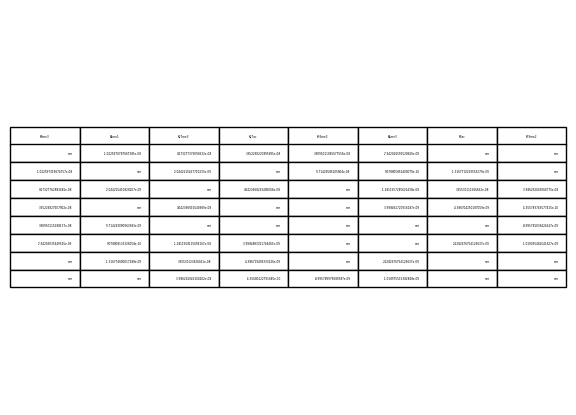

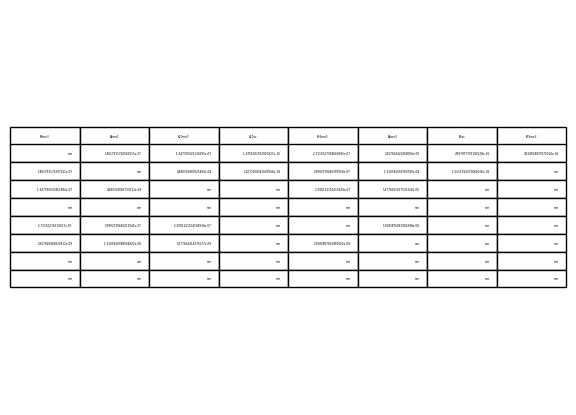

                            OLS Regression Results                            
Dep. Variable:            diff_levels   R-squared:                       0.531
Model:                            OLS   Adj. R-squared:                  0.530
Method:                 Least Squares   F-statistic:                     2125.
Date:                Mon, 06 Mar 2023   Prob (F-statistic):               0.00
Time:                        03:07:21   Log-Likelihood:            -1.4450e+05
No. Observations:               77109   AIC:                         2.891e+05
Df Residuals:                   77067   BIC:                         2.895e+05
Df Model:                          41                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

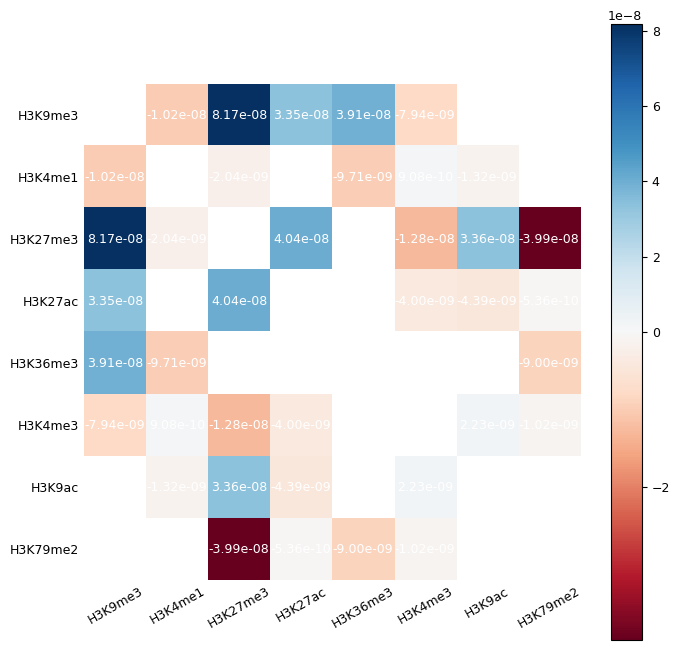

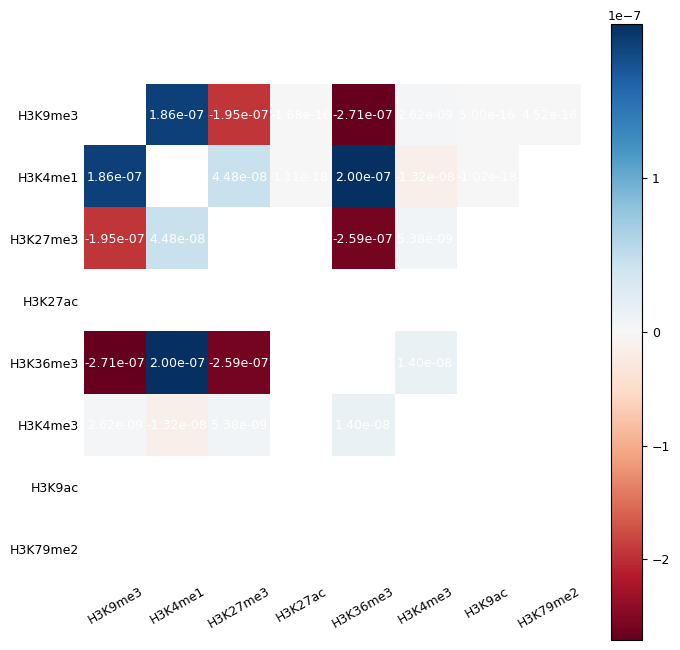

In [53]:
preloaded_getlinmodel_diff('K562', 'CACO2', ['H3K9me3', 'H3K4me1', 'H3K27me3', 'H3K27ac', 'H3K36me3', 'H3K4me3', 'H3K9ac', 'H3K79me2'], histone_levels, interact=True, dynamic=True, table=True)


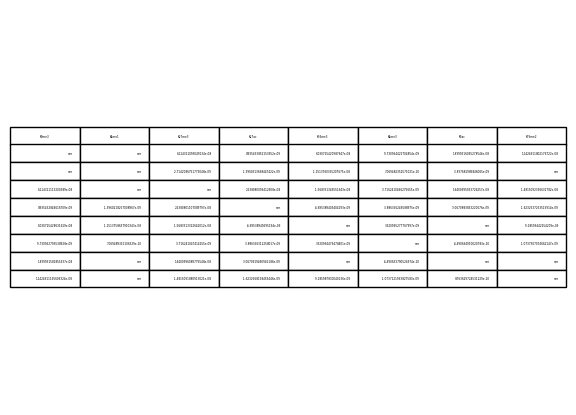

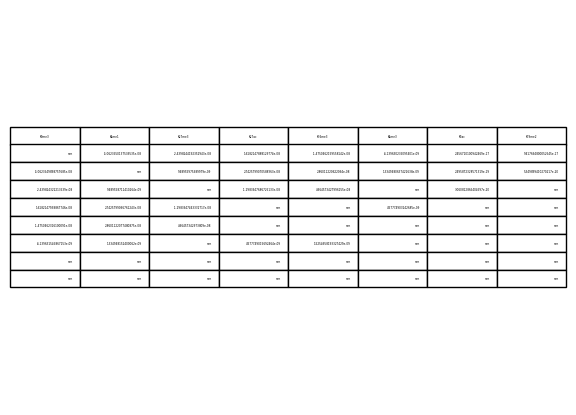

                            OLS Regression Results                            
Dep. Variable:            diff_levels   R-squared:                       0.649
Model:                            OLS   Adj. R-squared:                  0.649
Method:                 Least Squares   F-statistic:                     2740.
Date:                Mon, 06 Mar 2023   Prob (F-statistic):               0.00
Time:                        03:07:37   Log-Likelihood:            -1.3259e+05
No. Observations:               77109   AIC:                         2.653e+05
Df Residuals:                   77056   BIC:                         2.658e+05
Df Model:                          52                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  0

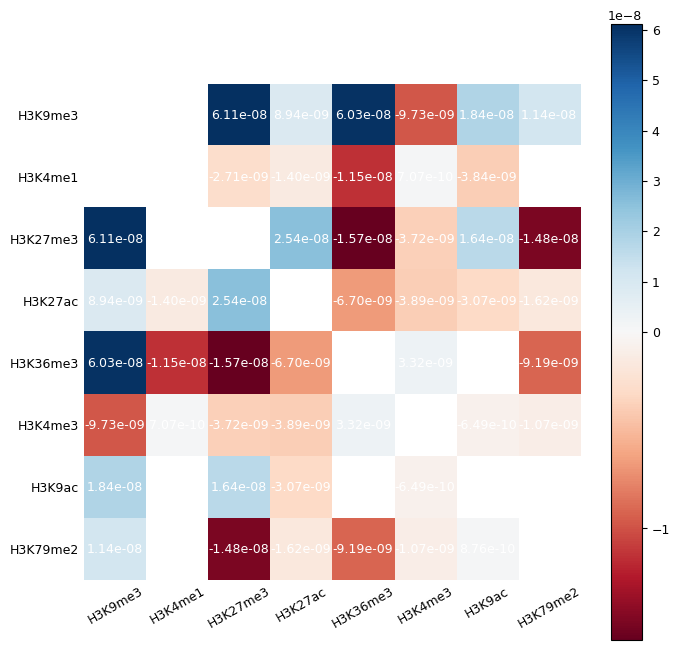

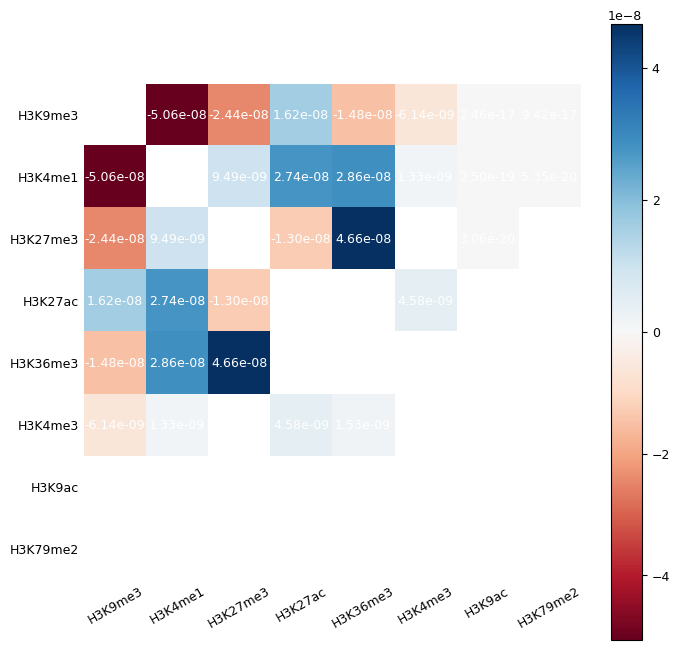

In [54]:
preloaded_getlinmodel_diff('K562', 'A673', ['H3K9me3', 'H3K4me1', 'H3K27me3', 'H3K27ac', 'H3K36me3', 'H3K4me3', 'H3K9ac', 'H3K79me2'], histone_levels, interact=True, dynamic=True, table=True)


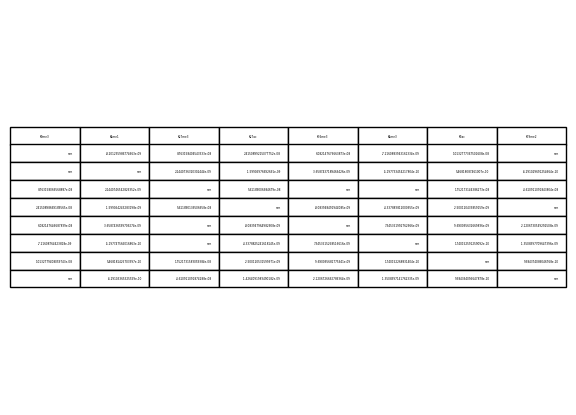

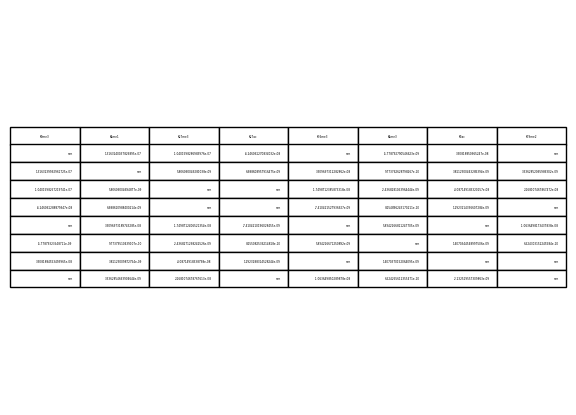

                            OLS Regression Results                            
Dep. Variable:            diff_levels   R-squared:                       0.663
Model:                            OLS   Adj. R-squared:                  0.663
Method:                 Least Squares   F-statistic:                     2367.
Date:                Mon, 06 Mar 2023   Prob (F-statistic):               0.00
Time:                        03:07:55   Log-Likelihood:            -1.2951e+05
No. Observations:               77109   AIC:                         2.591e+05
Df Residuals:                   77044   BIC:                         2.597e+05
Df Model:                          64                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

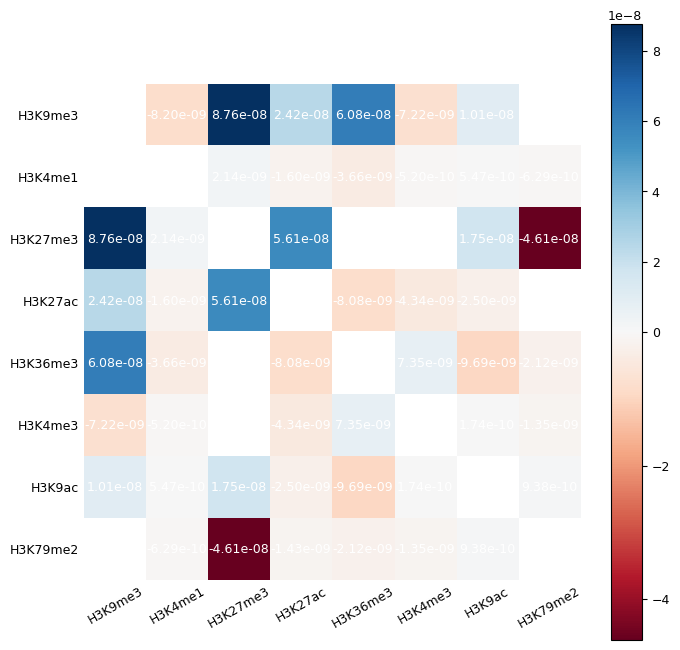

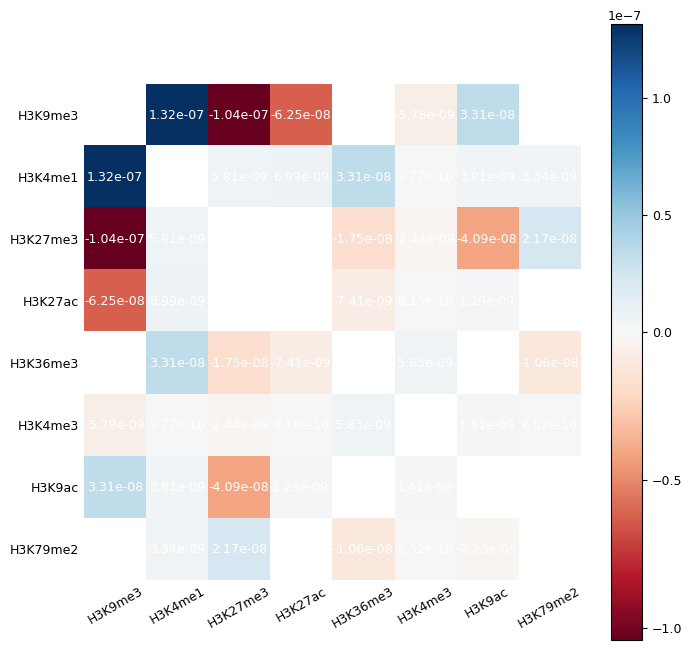

In [55]:
preloaded_getlinmodel_diff('K562', 'HUVEC', ['H3K9me3', 'H3K4me1', 'H3K27me3', 'H3K27ac', 'H3K36me3', 'H3K4me3', 'H3K9ac', 'H3K79me2'], histone_levels, interact=True, dynamic=True, table=True)


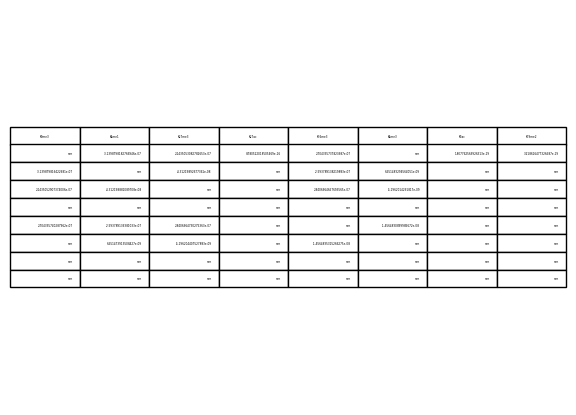

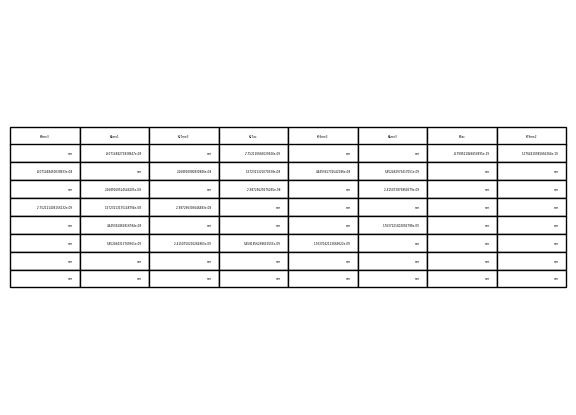

                            OLS Regression Results                            
Dep. Variable:            diff_levels   R-squared:                       0.635
Model:                            OLS   Adj. R-squared:                  0.635
Method:                 Least Squares   F-statistic:                     4629.
Date:                Mon, 06 Mar 2023   Prob (F-statistic):               0.00
Time:                        03:08:06   Log-Likelihood:            -1.4325e+05
No. Observations:               77109   AIC:                         2.866e+05
Df Residuals:                   77079   BIC:                         2.868e+05
Df Model:                          29                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

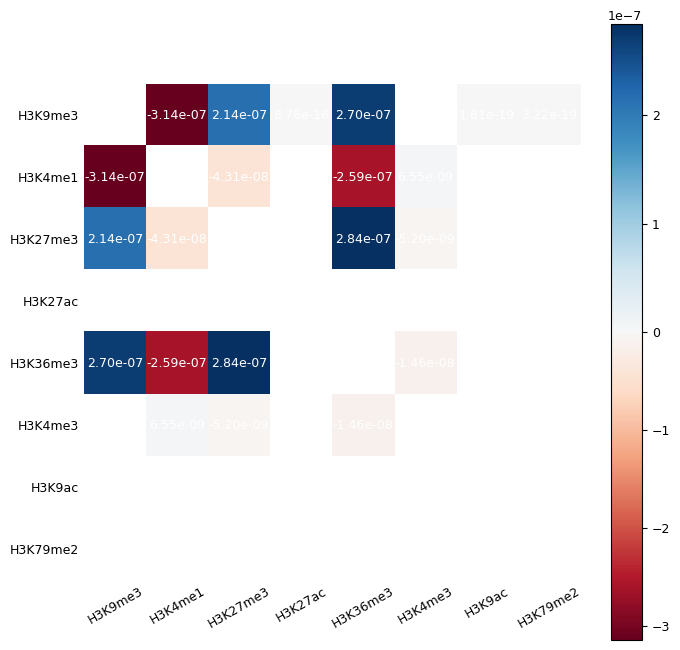

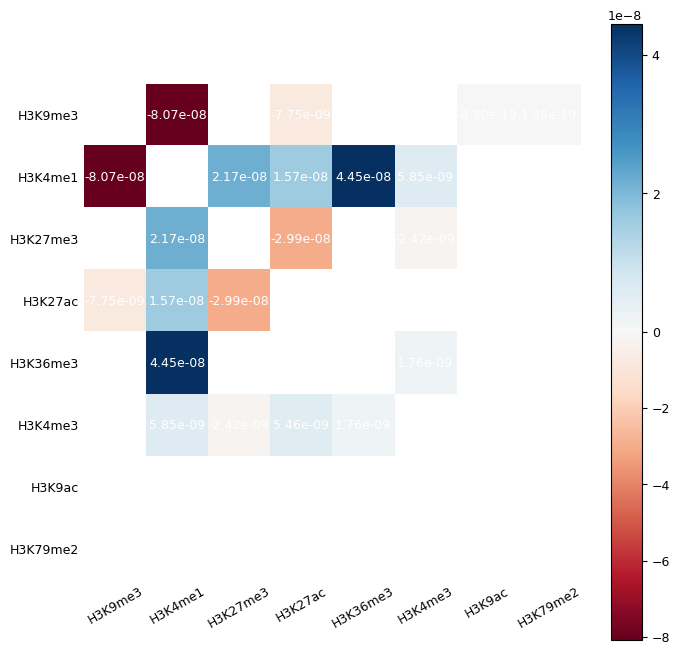

In [56]:
preloaded_getlinmodel_diff('CACO2', 'A673', ['H3K9me3', 'H3K4me1', 'H3K27me3', 'H3K27ac', 'H3K36me3', 'H3K4me3', 'H3K9ac', 'H3K79me2'], histone_levels, interact=True, dynamic=True, table=True)


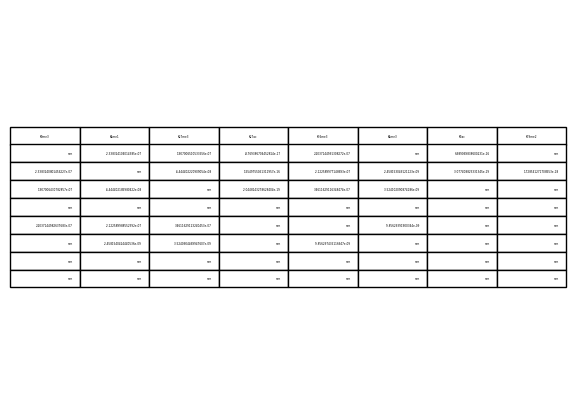

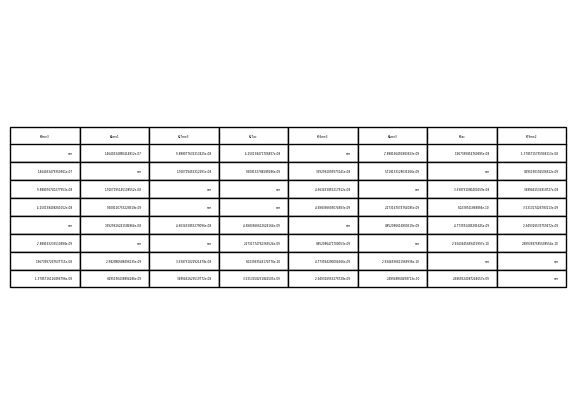

                            OLS Regression Results                            
Dep. Variable:            diff_levels   R-squared:                       0.605
Model:                            OLS   Adj. R-squared:                  0.605
Method:                 Least Squares   F-statistic:                     2570.
Date:                Mon, 06 Mar 2023   Prob (F-statistic):               0.00
Time:                        03:08:21   Log-Likelihood:            -1.4093e+05
No. Observations:               77109   AIC:                         2.820e+05
Df Residuals:                   77062   BIC:                         2.824e+05
Df Model:                          46                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

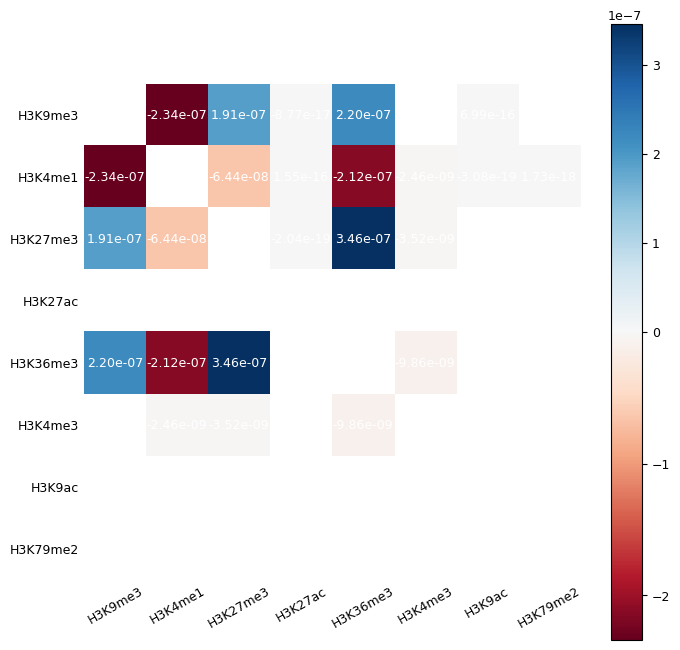

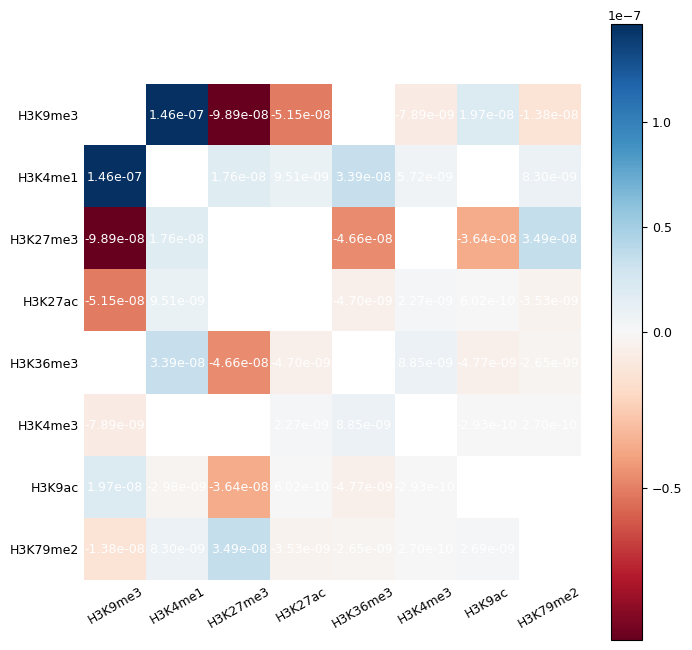

In [57]:
preloaded_getlinmodel_diff('CACO2', 'HUVEC', ['H3K9me3', 'H3K4me1', 'H3K27me3', 'H3K27ac', 'H3K36me3', 'H3K4me3', 'H3K9ac', 'H3K79me2'], histone_levels, interact=True, dynamic=True, table=True)


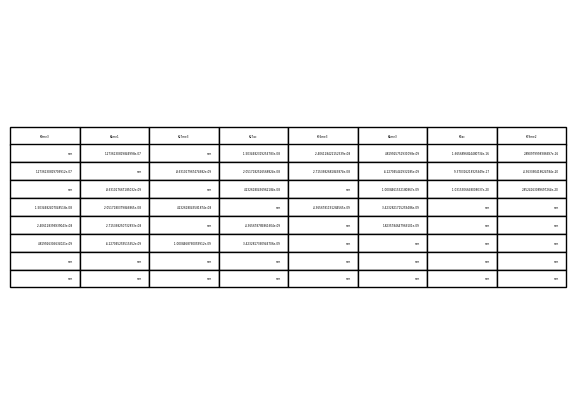

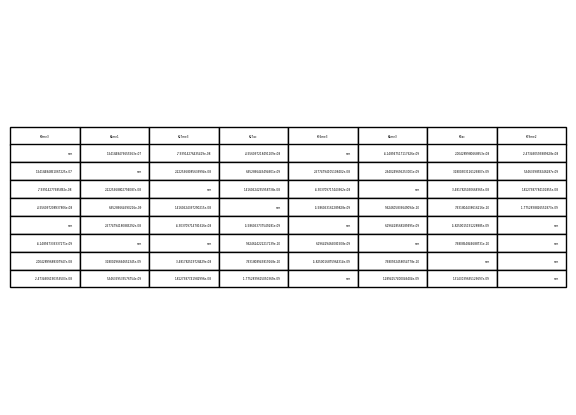

                            OLS Regression Results                            
Dep. Variable:            diff_levels   R-squared:                       0.645
Model:                            OLS   Adj. R-squared:                  0.645
Method:                 Least Squares   F-statistic:                     2690.
Date:                Mon, 06 Mar 2023   Prob (F-statistic):               0.00
Time:                        03:08:37   Log-Likelihood:            -1.2606e+05
No. Observations:               77109   AIC:                         2.522e+05
Df Residuals:                   77056   BIC:                         2.527e+05
Df Model:                          52                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

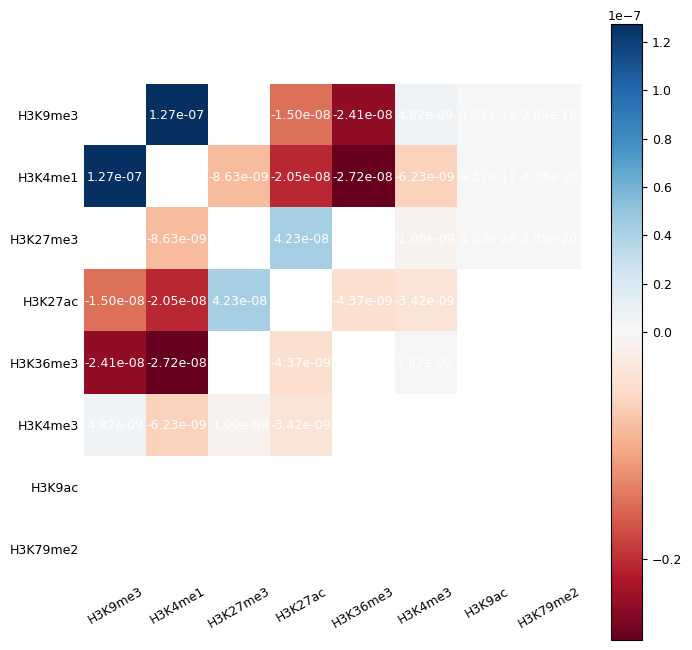

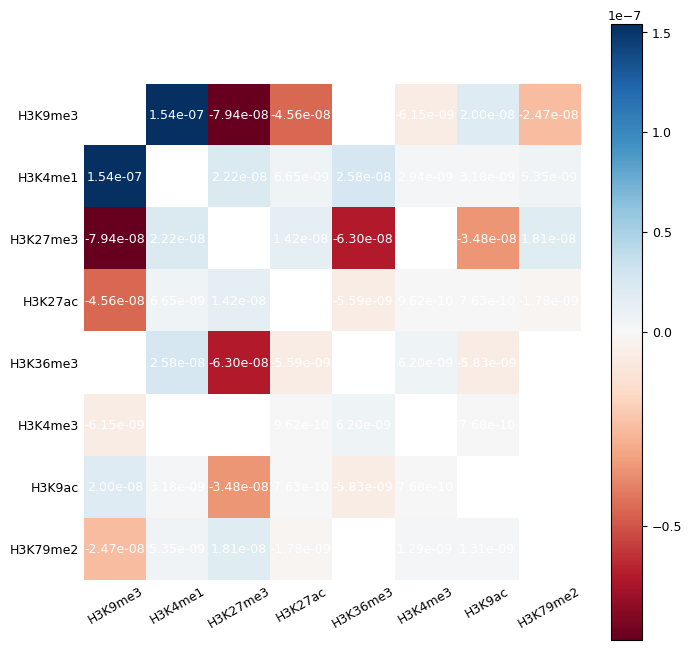

In [58]:
preloaded_getlinmodel_diff('A673', 'HUVEC', ['H3K9me3', 'H3K4me1', 'H3K27me3', 'H3K27ac', 'H3K36me3', 'H3K4me3', 'H3K9ac', 'H3K79me2'], histone_levels, interact=True, dynamic=True, table=True)


In [63]:
cell_pairs = [['K562', 'CACO2'], 
              ['K562', 'A673'],
              ['K562', 'HUVEC'], 
              ['CACO2', 'A673'], 
              ['CACO2', 'HUVEC'], 
              ['A673', 'HUVEC']]
cell_pairs_unformatted = ['K562', 'CACO2', 'K562', 'A673','K562', 'HUVEC', 'CACO2', 'A673', 'CACO2', 'HUVEC', 'A673', 'HUVEC']
cell_pair_names = ['K562_CACO2', 'K562_A673', 'K562_HUVEC', 'CACO2_A673', 'CACO2_HUVEC', 'A673_HUVEC']

data = np.zeros((6, 8))

for i in range(len(cell_pairs)):
    x = list(preloaded_getlinmodel_diffdiff(cell_pairs[i][0], cell_pairs[i][1], ['H3K9me3', 'H3K4me1', 'H3K27me3', 'H3K27ac', 'H3K36me3', 'H3K4me3', 'H3K9ac', 'H3K79me2'], histone_levels).params)[1::]
    print(x)
    for j in range(len(x)):
        data[i][j] = x[j]

print(data)

                            OLS Regression Results                            
Dep. Variable:            diff_levels   R-squared:                       0.282
Model:                            OLS   Adj. R-squared:                  0.282
Method:                 Least Squares   F-statistic:                     3781.
Date:                Mon, 06 Mar 2023   Prob (F-statistic):               0.00
Time:                        03:32:03   Log-Likelihood:            -1.6090e+05
No. Observations:               77109   AIC:                         3.218e+05
Df Residuals:                   77100   BIC:                         3.219e+05
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.9087      0.010    -90.582      0.0

/users/myin25/miniconda/envs/copro/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1918: RuntimeWarning: divide by zero encountered in scalar divide
  return np.sqrt(eigvals[0]/eigvals[-1])


                            OLS Regression Results                            
Dep. Variable:            diff_levels   R-squared:                       0.469
Model:                            OLS   Adj. R-squared:                  0.469
Method:                 Least Squares   F-statistic:                 1.135e+04
Date:                Mon, 06 Mar 2023   Prob (F-statistic):               0.00
Time:                        03:32:04   Log-Likelihood:            -1.5773e+05
No. Observations:               77109   AIC:                         3.155e+05
Df Residuals:                   77102   BIC:                         3.155e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.5941      0.010     61.104      0.0

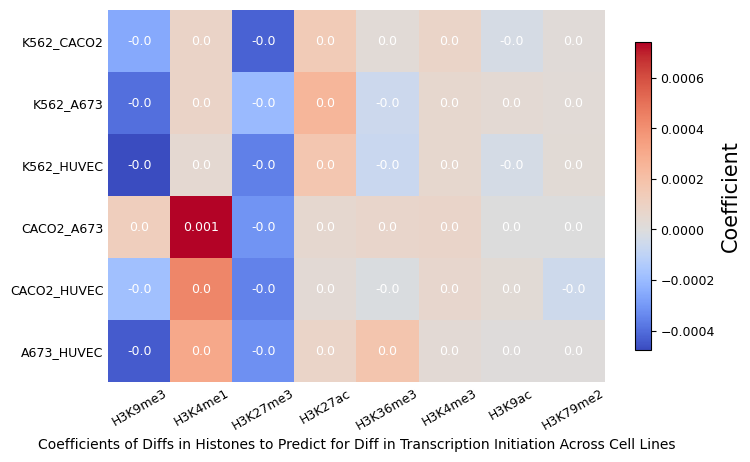

In [64]:
plot_params = {"xtick.labelsize": 9,
               "ytick.labelsize": 9}
plt.rcParams.update(plot_params)

plt.figure(figsize=(8,8))
# cmap = get_continuous_cmap(["#3B1F68", "#5F31A6", "#B197DA"])

cmap = matplotlib.cm.coolwarm

datamin = data.min()
datamax = data.max()
if datamin < 0:
    datarange = datamax - datamin
    percent_to0 = abs(datamin)/datarange

    cmap = shiftedColorMap(cmap, midpoint=percent_to0)

plt.imshow(data, cmap=cmap)

plt.xlabel('Coefficients of Diffs in Histones to Predict for Diff in Transcription Initiation Across Cell Lines', fontsize=10)

cb = plt.colorbar(shrink=0.5)
cb.set_label("Coefficient", fontsize=15)

ax = plt.gca()

for i in range(6):
    for j in range(len(histone_types)):
        coef = data[i, j]
        coef_str = str(round(coef, 3))
        text = ax.text(j, i, coef_str,
                       ha="center", va="center", color="w", fontsize=9)

for side in ["top", "right", "bottom", "left"]:
    ax.spines[side].set_visible(False)

ax.tick_params(length=0)

ax.set_xticks(range(len(histone_types)), histone_types, rotation=30)
ax.set_yticks(range(len(cell_pair_names)), cell_pair_names)

# plt.show()

plt.savefig('/users/myin25/projects/celltype_specificity/figures/linmodel_heatmaps_diff_log/diffhistone_allcells.png')
